In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

# listings_cleansed 

### Fill missing values in listing_cleansed 

In [2]:
df_listings_cleansed = pd.read_csv('../../data/all_cities/listings_cleansed_all.csv',index_col=False)

/home/ramon/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (120) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#### Drop useless columns

In [3]:
cols_drop = ['host_name','host_listings_count','room_type','cancellation_policy','last_scraped' ]
df_listings_cleansed.drop(cols_drop,axis=1,inplace=True)

#### Filter on active listings

In [4]:
df_listings_cleansed = df_listings_cleansed[df_listings_cleansed.availability_90 > 0]
df_listings_cleansed = df_listings_cleansed[df_listings_cleansed.last_review < 60]

#### Add listings count per host and multihost column

In [5]:
df_listings_cleansed['listings_per_host'] = df_listings_cleansed.groupby(
        ["host_id"])["listing_id"].transform("count")

df_listings_cleansed['multihost'] = (df_listings_cleansed.listings_per_host > 1) * 1

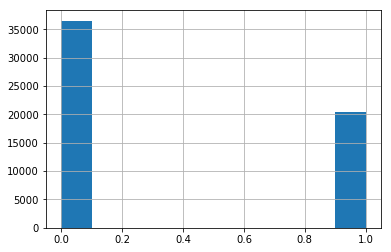

In [6]:
df_listings_cleansed['multihost'].hist()

#### Fill missing amenities, neighborhood, etc with zero

In [7]:
fill_na_zero_features = ['amenities','neighbourhood_group_cleansed','host_verification','property_type','bed_type_airbed']

cols_fill_na_zero = [c for c in df_listings_cleansed.columns if any(x in c for x in fill_na_zero_features)]
df_listings_cleansed[cols_fill_na_zero] = df_listings_cleansed[cols_fill_na_zero].fillna(0)

#### List columns with missing values 

In [8]:
df_missing_listings = pd.DataFrame(df_listings_cleansed.isnull().sum()/len(df_listings_cleansed)*100).sort_values(by=0,ascending=False)

df_missing_listings.columns = ['missing_percent']
df_missing_listings = df_missing_listings[df_missing_listings.missing_percent>0]
df_missing_listings = df_missing_listings.sort_index()
cols_fill_missing_mean= df_missing_listings.index.tolist()
df_missing_listings

,missing_percent
bathrooms,0.145903
bedrooms,0.147661
beds,0.026368
host_response_rate,0.128325
host_response_time,0.128325
host_since,0.001758
last_update_days,21.544465
review_scores_accuracy,0.325206
review_scores_checkin,0.337511
review_scores_cleanliness,0.284775


#### Fill missing values with mean of city

In [9]:
df_listings_cleansed[df_listings_cleansed.last_update_days.isnull()][['number_of_reviews','last_review']].head()

,number_of_reviews,last_review
7,1,1.0
19,31,11.0
38,1,5.0
39,13,37.0
41,1,15.0


In [10]:
print df_listings_cleansed[df_listings_cleansed.city=='amsterdam'].last_update_days.head(3)
print df_listings_cleansed[df_listings_cleansed.city=='roma'].last_update_days.head(3)

1    21.0
4     7.0
7     NaN
Name: last_update_days, dtype: float64
87427    NaN
87428    7.0
87429    0.0
Name: last_update_days, dtype: float64


In [11]:
df_listings_cleansed[cols_fill_missing_mean] = df_listings_cleansed.groupby("city")[cols_fill_missing_mean].transform(lambda x: x.fillna(x.mean()))

In [12]:
print df_listings_cleansed[df_listings_cleansed.city=='amsterdam'].last_update_days.head(3)
print df_listings_cleansed[df_listings_cleansed.city=='roma'].last_update_days.head(3)

1    21.000000
4     7.000000
7    10.509564
Name: last_update_days, dtype: float64
87427    9.072619
87428    7.000000
87429    0.000000
Name: last_update_days, dtype: float64


In [13]:
df_missing_listings = pd.DataFrame(df_listings_cleansed.isnull().sum()/len(df_listings_cleansed)*100).sort_values(by=0,ascending=False)

df_missing_listings.columns = ['missing_percent']
df_missing_listings = df_missing_listings[df_missing_listings.missing_percent>0]
df_missing_listings = df_missing_listings.sort_index()
cols_fill_missing_mean= df_missing_listings.index.tolist()
df_missing_listings

,missing_percent


### Create city categories 

In [14]:
df_city_categorie = pd.get_dummies(df_listings_cleansed.city)
df_listings_cleansed.drop('city',axis=1,inplace=True)
df_city_categorie.head(1)

,amsterdam,antwerp,athens,barcelona,berlin,brussels,dublin,geneva,london,madrid,paris,roma,venice,vienna
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
df_listings_cleansed = pd.concat([df_listings_cleansed,df_city_categorie],axis=1)

In [16]:
cols_num = df_listings_cleansed.select_dtypes(['number']).columns.tolist()
cols_not_num = set(df_listings_cleansed.columns.tolist())-set(cols_num)
cols_not_num

set()

In [17]:
df_listings_cleansed.to_csv('../../data/all_cities/listing_cleansed_fillna.csv',index=False)

# Add Reviews frequency

In [18]:
df_listings_cleansed= pd.read_csv('../../data/all_cities/listing_cleansed_fillna.csv',index_col=False)
df_reviews_frequency_all = pd.read_csv('../../data/all_cities/reviews_frequency_all.csv')
df_reviews_frequency_all = df_reviews_frequency_all.fillna(0)
df_reviews_frequency_all.drop('city',axis=1,inplace=True)
df_listings_cleansed = pd.merge(df_listings_cleansed,df_reviews_frequency_all,on='listing_id')

# Add reviews_language ratio

In [19]:
df_review_with_lang = pd.read_csv('../../data/all_cities/reviews_language_all.csv',index_col=0)
print df_review_with_lang.shape

df_review_with_lang = pd.merge(df_listings_cleansed[['listing_id']],df_review_with_lang,on='listing_id')
print df_review_with_lang.shape

groupy_lang_review = df_review_with_lang.groupby(['listing_id','language'])[['id']].count().unstack().fillna(0)
groupy_lang_review.columns = groupy_lang_review.columns.droplevel()
groupy_lang_review = groupy_lang_review.reset_index()
groupy_lang_review=groupy_lang_review.astype(int)

groupy_lang_review.iloc[:, 1:] = groupy_lang_review.iloc[:, 1:].apply(lambda x: x*100.0 / x.sum(),axis=1)


cols_ratio_lang = ['review_ratio_'+c for c in groupy_lang_review.columns.tolist()[1:]]
groupy_lang_review.columns = ['listing_id']+cols_ratio_lang

/home/ramon/anaconda2/lib/python2.7/site-packages/numpy/lib/arraysetops.py:395: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


(2416585, 4)
(2031532, 4)


In [20]:
groupy_lang_review =groupy_lang_review.astype(int)
print groupy_lang_review.shape

(56882, 46)


In [21]:
df_listings_cleansed = pd.merge(df_listings_cleansed,groupy_lang_review,on='listing_id')

In [22]:
df_listings_cleansed.shape

(56882, 323)

# Add reviews PCA

In [23]:
df_review_PCA = pd.read_csv('../../data/all_cities/reviews_PCA_all.csv')
print df_review_PCA.shape

(56887, 21)


In [24]:
df_review_PCA.head()

,listing_id,reviews_pc_1,reviews_pc_2,reviews_pc_3,reviews_pc_4,reviews_pc_5,reviews_pc_6,reviews_pc_7,reviews_pc_8,reviews_pc_9,...,reviews_pc_11,reviews_pc_12,reviews_pc_13,reviews_pc_14,reviews_pc_15,reviews_pc_16,reviews_pc_17,reviews_pc_18,reviews_pc_19,city
0,16590973,0.255008,-0.025034,-0.084033,0.024888,-0.055772,0.094112,0.045136,-0.072911,-0.096355,...,-0.007796,0.059378,0.061623,-0.047046,0.040242,0.089166,0.029728,-0.143098,0.022957,amsterdam
1,8024854,1.542527,0.590932,-0.265455,-0.086997,-0.060118,-0.410276,-0.146006,-0.011183,0.100233,...,0.005264,0.220025,-0.079162,-0.077951,0.012836,0.083547,-0.186142,0.053036,-0.127600,amsterdam
2,2117111,0.172423,-0.104302,0.119291,-0.075284,0.116812,0.145338,0.037120,-0.136319,-0.170814,...,-0.069308,-0.024339,-0.004917,-0.014024,0.098061,-0.053479,0.032714,0.052302,0.018001,amsterdam
3,17312436,0.340857,-0.236270,-0.126112,-0.001532,-0.030504,-0.057160,-0.108607,-0.028863,0.043528,...,-0.107899,-0.152710,0.011346,-0.103760,0.057315,-0.086389,0.013302,-0.008431,0.212630,amsterdam
4,6110143,0.928086,-0.213038,-0.169772,-0.189467,-0.135179,-0.321734,0.061121,-0.113399,-0.119609,...,0.038347,0.276933,-0.114159,0.241956,-0.130586,-0.002236,0.034677,-0.108452,0.026622,amsterdam


In [25]:
df_review_PCA.drop('city',axis=1,inplace=True)

In [26]:
df_listings_cleansed = pd.merge(df_listings_cleansed,df_review_PCA,on='listing_id')

In [27]:
df_listings_cleansed.shape

(56882, 342)

#  Add pictures brightness and PCA

In [28]:
df_pictures_contrast_brightness = pd.read_csv('../../data/all_cities/pictures_contrasts_brightness_all.csv')
df_pictures_PCA = pd.read_csv('../../data/all_cities/pictures_PCA_all.csv',index_col=False)
df_pictures_PCA.drop('unnamed: 0',axis=1,inplace=True)
print df_pictures_contrast_brightness.shape
print df_pictures_PCA.shape

(56884, 7)
(56884, 52)


In [29]:
df_pictures_contrast_brightness.drop('city',axis=1,inplace=True)
df_pictures_contrast_brightness.head()

,listing_id,r_contrast,g_contrast,b_contrast,brightness_mean,brightness_std
0,16590973,58,60,66,122,58
1,8024854,40,42,45,145,42
2,2117111,52,51,52,99,51
3,17312436,49,49,52,177,49
4,6110143,62,64,65,97,63


In [30]:
print df_listings_cleansed.shape

(56882, 342)


In [31]:
df_listings_cleansed = pd.merge(df_listings_cleansed,df_pictures_PCA,on='listing_id')
df_listings_cleansed = pd.merge(df_listings_cleansed,df_pictures_contrast_brightness,on='listing_id')

In [32]:
print df_listings_cleansed.shape

(56879, 398)


In [33]:
df_listings_cleansed.isnull().sum().value_counts()

0    398
dtype: int64

# Save clean dataset without NA

In [34]:
df_listings_cleansed.to_csv('../../data/all_cities/listing_cleansed_fillna.csv',index=False)

In [35]:
[x for x in df_listings_cleansed.columns.tolist() if 'city' in x]

['city']